# import

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
import bioframe
import bbi
import pyBigWig
from sklearn.isotonic import IsotonicRegression
import cooler
import hicstraw
from scipy.stats import zscore
%cd /cluster/home/futing/Project/GBM/HiC/13mutation/TCGA

# font_manager.fontManager.addfont('/cluster/home/futing/miniforge-pypy3/envs/hic/fonts/Arial.ttf')
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42

/cluster/home/futing/Project/GBM/HiC/13mutation/TCGA


# Section 1: calculate SM load per gene

### Contact Frequency

#### 导入数据

In [ ]:
# 导入自己的RNA，meta，genebed
RNAexp=pd.read_csv('/cluster/home/futing/Project/GBM/RNA/merge/merged_RNA.txt',sep="\t")
summary=pd.read_csv("/cluster/home/futing/Project/GBM/RNA/merge/summary.txt",sep="\t",index_col=0)
id=summary.loc[summary['kmeans'].notna(),'id']
genetran=pd.read_csv('/cluster/home/futing/ref_genome/hg38_gencode/genebed/geneid.txt',sep='\t')

In [ ]:
RNAexp=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation_tcga/RNA.txt',sep='\t')
RNAexp.columns=RNAexp.columns.str.replace('.','-')

In [ ]:
RNAexp.dropna(subset=['SYMBOL'],inplace=True)
RNAexp.drop(columns=['Entrez_Gene_Id'],inplace=True)
RNAexp.set_index('SYMBOL',inplace=True)
RNAexp=RNAexp.T

#### 所有的

In [ ]:
id=SNP_loop_ss['Tumor_Sample_Barcode'].unique()

In [ ]:
SMload=SNP_loop_ss.groupby('symbol')['hg38id'].count().sort_values(ascending=False) # 每个symbol有多少的hg19id
# SNP_loop_ss.groupby('Hugo_Symbol')['hg19id'].count().sort_values(ascending=False) #每个原始的hugo_symbol有多少的hg19id
SMload.head()

symbol
Y_RNA      665
TTN        229
TTN-AS1    229
TP53       174
PTEN       155
Name: hg38id, dtype: int64

In [ ]:
# 合并 RNA exp 和 SMload 为 corRNA
RNAexp_fil=RNAexp.loc[RNAexp.index.isin(id),:]
RNAexp_filmean=RNAexp_fil.mean(axis=0)
RNAexp_filmean.name = "RNAexp"
SMload.name = "SMload"
corRNA=pd.merge(RNAexp_filmean,SMload,left_index=True,right_index=True,how='inner')

In [ ]:
corRNA.to_csv('corRNA.txt',sep='\t')

In [ ]:
corRNAlist=pd.merge(RNAexp_fil.T,SMload,left_index=True,right_index=True,how='inner')
corlist=corRNAlist.iloc[:,:-1].apply(lambda x: x.corr(corRNAlist['SMload']),axis=0)

In [ ]:
corlist.sort_values(ascending=False)

TCGA-28-5218-01A    0.010966
TCGA-06-0744-01A    0.009313
TCGA-06-0190-02A    0.007488
TCGA-06-0187-01A    0.006709
TCGA-06-0686-01A    0.005815
                      ...   
TCGA-06-5417-01A   -0.012459
TCGA-27-2521-01A   -0.013455
TCGA-41-5651-01A   -0.013577
TCGA-12-0618-01A   -0.014025
TCGA-14-1825-01A   -0.017006
Length: 157, dtype: float64

In [ ]:

corRNA['zscoreRNA']=zscore(np.log10(corRNA['RNAexp']+1))
corRNA['SMloadlog']=np.log10(corRNA['SMload']+1)

In [ ]:
print(corRNA['RNAexp'].corr(corRNA['SMload']))
print(corRNA['zscoreRNA'].corr(corRNA['SMload']))
print(corRNA['zscoreRNA'].corr(corRNA['SMloadlog']))

-0.004299976021151505
-0.04432696899483998
-0.0482661750822508


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'F', 'L', 'M', 'N', 'O', 'R', 'S', 'a', 'c', 'd', 'e', 'five', 'four', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'space', 'three', 'two', 'u', 'v', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 36, 41, 47, 48, 49, 50, 53, 54, 68, 70, 71, 72, 79, 81, 82, 83, 84, 85, 86, 88, 89, 92, 93, 237]
INFO:fontTools.subset:Closed glyph list over 'G

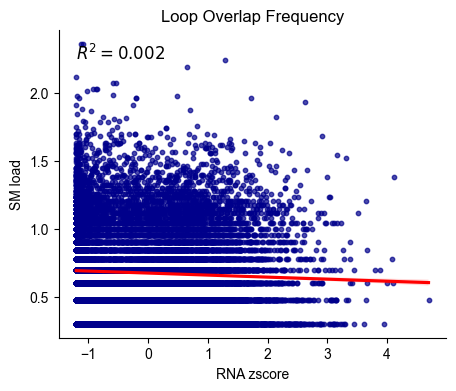

In [ ]:
from scipy.stats import linregress
# 回归线
x = corRNA['zscoreRNA']
y = corRNA['SMloadlog']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.7}, line_kws={'color': 'red'},color='darkblue')

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=12, color='black'
)

# 设置标题和标签
plt.title('Loop Overlap Frequency', fontsize=12)
plt.xlabel('RNA zscore', fontsize=10)
plt.ylabel('SM load', fontsize=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.yscale('log')
# plt.grid(alpha=0.3)
plt.savefig('RNAexp_SMload_freq.pdf',dpi=300,bbox_inches='tight')

In [ ]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=RNA_zscore, y=log_SM_load, alpha=0.3, s=15)

# 添加非线性拟合曲线（LOESS 示例）
sns.regplot(x=RNA_zscore, y=log_SM_load, scatter=False, color='red', lowess=True)

# 计算线性回归
slope, intercept, r_value, _, _ = linregress(RNA_zscore, log_SM_load)
plt.plot(RNA_zscore, slope * RNA_zscore + intercept, color='blue', label=f'Linear R²={r_value**2:.3f}')


#### 仅考虑 无义突变

In [ ]:
SNP_loop_ss=pd.merge(SNP_loop_ss,SNP[['hg38id','Variant_Classification']],on='hg38id',how='left')

In [ ]:
SM_mis=SNP_loop_ss.loc[SNP_loop_ss['Variant_Classification']=='Nonsense_Mutation',:]

In [ ]:
SNP_loop_ss['Variant_Classification'].value_counts()

Variant_Classification
Missense_Mutation         103800
Silent                     36410
Frame_Shift_Ins             9990
Nonsense_Mutation           7534
Frame_Shift_Del             2724
RNA                         2243
Splice_Site                 2074
Intron                      1808
5'Flank                     1218
Splice_Region               1019
In_Frame_Del                 701
3'Flank                      661
3'UTR                        386
5'UTR                        238
In_Frame_Ins                 224
Nonstop_Mutation              83
Translation_Start_Site        57
Name: count, dtype: int64

#### 仅考虑一端是基因一端是SM的情况

In [ ]:
SM_looponly=pd.merge(SNP_loop_ss,genebed,on='symbol',how='left')

In [ ]:
SM_looponly.loc[:,'inGene']=np.where(
    SM_looponly[['chr_y', 'start_y', 'end_y']].isna().any(axis=1),
    np.nan,  # 如果有任何 NA，则设置为 NA  发现有些基因没有匹配的位置信息
    np.where(
        (SM_looponly['start_x']>=SM_looponly['start_y']) & (SM_looponly['end_x']<=SM_looponly['end_y']),
        1,
        0
    )
)

In [ ]:
# 那么对于原位的 hg19id 呢？
SNP_loop_ss.loc[:,'inGene']=SM_looponly.loc[:,'inGene']

In [ ]:
print(SM_looponly['inGene'].value_counts())
print(SM_looponly['inGene'].isna().sum()) #2408 和前面的没有gene交集的loop的数量一样
print(SM_looponly['inGene'].shape) #42780

inGene
1.0    64185
0.0    57479
Name: count, dtype: int64
4944
(126608,)


In [ ]:
# 挑选loop交集的数据
SMloadonly=SNP_loop_ss.loc[SNP_loop_ss['inGene']==0,:].groupby('symbol')['hg38id'].count().sort_values(ascending=False)

In [ ]:
# 合并 RNA exp 和 SMload 为 corRNA
RNAexp_fil=RNAexp.loc[RNAexp.index.isin(id),:]
RNAexp_filmean=RNAexp_fil.mean(axis=0)
RNAexp_filmean.name = "RNAexp"
SMloadonly.name = "SMload"
corRNAonly=pd.merge(RNAexp_filmean,SMloadonly,left_index=True,right_index=True,how='inner')

In [ ]:
corRNAonly.to_csv('freqRNAonly.txt',sep='\t')

In [ ]:
corRNAex=pd.merge(RNAexp_fil.T,SMloadonly,left_index=True,right_index=True,how='inner')
corRNAex.iloc[:,:-1]=corRNAex.iloc[:,:-1].apply(lambda x: zscore(np.log10(x+1)))
corRNAex.iloc[:,:-1].apply(lambda x: x.corr(corRNAex['SMload']),axis=0).sort_values(ascending=False)

TCGA-06-0743-01A   -0.005881
TCGA-41-2571-01A   -0.009186
TCGA-06-1804-01A   -0.009322
TCGA-32-2632-01A   -0.012248
TCGA-19-2625-01A   -0.013335
                      ...   
TCGA-02-0047-01A   -0.039020
TCGA-06-0125-02A   -0.039903
TCGA-06-5417-01A   -0.041306
TCGA-06-5858-01A   -0.041552
TCGA-06-0221-02A   -0.041788
Length: 157, dtype: float64

In [ ]:
from scipy.stats import zscore
corRNAonly['zscoreRNA']=zscore(np.log10(corRNAonly['RNAexp']+1))

In [ ]:
print(corRNAonly['RNAexp'].corr(corRNAonly['SMload']))
print(corRNAonly['zscoreRNA'].corr(corRNAonly['SMload']))

-0.0025992812519348555
-0.026510101844617447


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'F', 'L', 'M', 'N', 'R', 'S', 'a', 'c', 'd', 'e', 'eight', 'f', 'four', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'q', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 25, 27, 36, 38, 41, 47, 48, 49, 53, 54, 68, 70, 71, 72, 73, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92, 93, 2

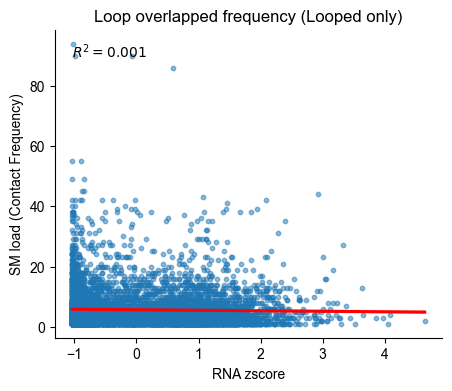

In [ ]:
from scipy.stats import linregress
# 回归线
x = corRNAonly['zscoreRNA']
y = corRNAonly['SMload']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=10, color='black'
)

# 设置标题和标签
plt.title('Loop overlapped frequency (Looped only)', fontsize=12)
plt.xlabel('RNA zscore', fontsize=10)
plt.ylabel('SM load (Contact Frequency)', fontsize=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.yscale('log')
# plt.grid(alpha=0.3)
plt.savefig('RNA_SMload_freq_looped.pdf',dpi=300,bbox_inches='tight')

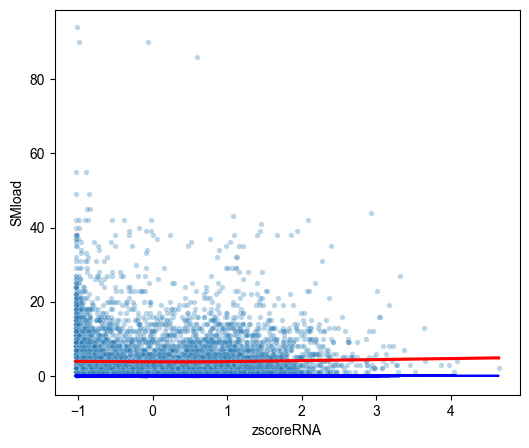

In [ ]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=x, y=y, alpha=0.3, s=15)

# 添加非线性拟合曲线（LOESS 示例）
sns.regplot(x=x, y=y, scatter=False, color='red', lowess=True)

# 计算线性回归
slope, intercept, r_value, _, _ = linregress(y, x)
plt.plot(x, slope *y + intercept, color='blue', label=f'Linear R²={r_value**2:.3f}')


### HiC contact

In [ ]:
SNP_loop_ss.head()

,index,hg38id,loopid,Tumor_Sample_Barcode,ENSG,symbol,genetype,chr1,start1,end1,chr2,start2,end2,chr,start,end,rawcontact,inGene,contact
0,2,chr1_154176176_154176176,NaN,TCGA-02-0003-01A,ENSG00000143549.22,TPM3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr1,154176175,154176176,NaN,1.0,NaN
1,3,chr10_122050517_122050517,NaN,TCGA-02-0003-01A,ENSG00000138162.19,TACC2,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr10,122050516,122050517,NaN,1.0,NaN
2,4,chr10_132153945_132153945,NaN,TCGA-02-0003-01A,ENSG00000188385.13,JAKMIP3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr10,132153944,132153945,NaN,1.0,NaN
3,5,chr11_90135669_90135669,NaN,TCGA-02-0003-01A,ENSG00000077616.11,NAALAD2,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr11,90135668,90135669,NaN,1.0,NaN
4,6,chr11_124619643_124619643,NaN,TCGA-02-0003-01A,ENSG00000154143.3,PANX3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr11,124619642,124619643,NaN,1.0,NaN


In [ ]:
# 对于原位 hg38id 的contact
ConInGene=SNP_loop_ss.loc[SNP_loop_ss['inGene']==1,:].groupby('symbol')['contact'].sum().sort_values(ascending=False)
ConInGene=pd.merge(ConInGene,RNAexp_filmean,left_index=True,right_index=True,how='inner')
ConInGene=ConInGene.apply(lambda x: zscore(np.log10(x+1)))

In [ ]:
print(ConInGene['contact'].corr(ConInGene['RNAexp']))

0.033476649919875624


In [ ]:
# 对于所有的 hg19id 的 contact
# Con=SNP_loop_ss.groupby('symbol')['contact'].sum().sort_values(ascending=False)
Conrawall=SNP_loop_ss.groupby('symbol')['rawcontact'].sum().sort_values(ascending=False)
ConRNAall=pd.merge(Conrawall,RNAexp_filmean,left_index=True,right_index=True,how='inner')
ConRNAall=ConRNAall.apply(lambda x: zscore(np.log10(x+1)),axis=0)
print(ConRNAall['rawcontact'].corr(ConRNAall['RNAexp']))

-0.0682349281164921


In [ ]:
# 对于在loop上的 hg38id 的 contact
Con=SNP_loop_ss.loc[SNP_loop_ss['inGene']==0,:].groupby('symbol')['contact'].sum().sort_values(ascending=False)
# Conraw=SNP_loop_ss.loc[SNP_loop_ss['inGene']==0,:].groupby('symbol')['rawcontact'].sum().sort_values(ascending=False)
# SNP_loop_ss.groupby('symbol')['hg19id'].count().sort_values(ascending=False)
ConRNA=pd.merge(RNAexp_filmean,Con,left_index=True,right_index=True,how='inner')
ConRNA=ConRNA.apply(lambda x: zscore(np.log10(x+1)),axis=0)
# ConRNA=pd.merge(ConRNA,Conraw,left_index=True,right_index=True,how='inner')
print(ConRNA['contact'].corr(ConRNA['RNAexp']))

-0.03787815729710572


In [ ]:
ConRNA['contact'].mean(),ConRNA['contact'].std()

(-6.161082175823862e-17, 1.000074757971173)

In [ ]:
ConRNA.to_csv('ConRNA_looped_ICE.txt',sep='\t')
ConRNAall.to_csv('ConRNA_all_ICE.txt',sep='\t')
ConInGene.to_csv('ConInGene_ICE.txt',sep='\t')

In [ ]:
# print(ConRNA['zscoreRNA'].corr(ConRNA['zscorecont']))
# print(ConRNA['zscoreRNA'].corr(ConRNA['contact']))
# print(ConRNA['zscoreRNA'].corr(ConRNA['rawcontact']))
# print(ConRNA['zscoreRNA'].corr(ConRNA['zscoreconraw']))

0.04840362927626777
0.04306598254466048
0.04406803004480682
0.08313265525265312


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 35 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'H', 'M', 'N', 'R', 'S', 'a', 'c', 'd', 'e', 'five', 'four', 'hyphen', 'i', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'period', 'r', 's', 'space', 't', 'three', 'two', 'w', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 36, 38, 43, 48, 49, 53, 54, 68, 70, 71, 72, 76, 79, 81, 82, 85, 86, 87, 90, 93, 237]
INFO:fontTools.subset:Clo

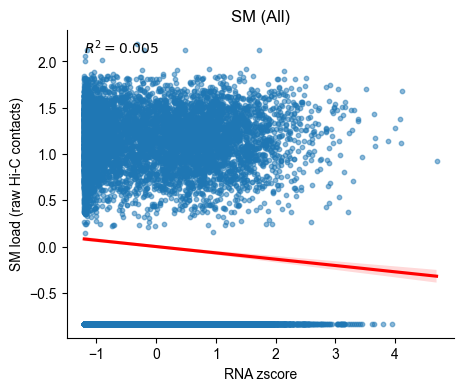

In [ ]:
from scipy.stats import linregress

# all ConRNAall['RNAexp'] ConRNAall['rawcontact']
# inGene ConInGene['RNAexp'] ConInGene['rawcontact']
# inLoop ConRNA['zscoreRNA'] conRNA['zscoreconraw']
x = ConRNAall['RNAexp']
y = ConRNAall['rawcontact']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=10, color='black'
)

# 设置标题和标签
plt.title('SM (All)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('RNA zscore', fontsize=10)
plt.ylabel('SM load (raw Hi-C contacts)', fontsize=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.yscale('log')
# plt.grid(alpha=0.3)
plt.savefig('RNA_SMload_all_hic.pdf',dpi=300,bbox_inches='tight')

# Section 2: calculate gene load per SM

In [ ]:
SNP_loop_ss.loc[:,'ENSG']=SNP_loop_ss['ENSG'].str.split('.').str[0]

In [ ]:
SNP_loop_ss.head()

,index,hg38id,loopid,Tumor_Sample_Barcode,ENSG,symbol,genetype,chr1,start1,end1,chr2,start2,end2,chr,start,end,rawcontact,inGene,contact
0,2,chr1_154176176_154176176,NaN,TCGA-02-0003-01A,ENSG00000143549.22,TPM3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr1,154176175,154176176,NaN,1.0,NaN
1,3,chr10_122050517_122050517,NaN,TCGA-02-0003-01A,ENSG00000138162.19,TACC2,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr10,122050516,122050517,NaN,1.0,NaN
2,4,chr10_132153945_132153945,NaN,TCGA-02-0003-01A,ENSG00000188385.13,JAKMIP3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr10,132153944,132153945,NaN,1.0,NaN
3,5,chr11_90135669_90135669,NaN,TCGA-02-0003-01A,ENSG00000077616.11,NAALAD2,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr11,90135668,90135669,NaN,1.0,NaN
4,6,chr11_124619643_124619643,NaN,TCGA-02-0003-01A,ENSG00000154143.3,PANX3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr11,124619642,124619643,NaN,1.0,NaN


In [ ]:
symbol_matrix = SNP_loop_ss.pivot_table(
    index='Tumor_Sample_Barcode',
    columns='hg19id',
    values='symbol',
    aggfunc=lambda x: ' '.join(x.dropna().astype(str).unique())
)
symbol_matrix.head()

hg19id,chr10_100017842_100017842,chr10_100183413_100183413,chr10_100481428_100481428,chr10_100481448_100481448,chr10_101295226_101295226,chr10_101646280_101646280,chr10_101689847_101689847,chr10_101716420_101716420,chr10_102822720_102822720,chr10_102896495_102896495,...,chrX_99854068_99854068,chrX_99854625_99854625,chrY_23710716_23710716,chrY_23710825_23710825,chrY_3447670_3447670,chrY_3447809_3447809,chrY_4925071_4925071,chrY_4925496_4925496,chrY_5605441_5605441,chrY_9304672_9304672
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
C3L-00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00365,NaN,NaN,NaN,NaN,NaN,NaN,DNMBP-AS1 DNMBP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00677,NaN,ENSG00000230928 LOXL4 PYROXD2 MIR4685,NaN,NaN,NaN,NaN,NaN,DNMBP-AS1 DNMBP,ENSG00000236662 TWNK MRPL43 LZTS2 ENSG00000273...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-01040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TNMD,NaN,NaN,NaN,NaN,NaN,PCDH11Y,NaN,NaN,NaN


In [ ]:
SMgene=SNP_loop_ss.loc[SNP_loop_ss['genetype']=='protein_coding',['hg38id','loopid','Tumor_Sample_Barcode','ENSG','symbol','genetype','score','contact','rawcontact','inGene']]
#SNP_loop_simple['genetype']=='protein_coding'
SMgene.drop_duplicates(inplace=True)
SMgene.dropna(subset=['ENSG'],inplace=True)
SMgene.shape #10464 25268(21292 dropna)

(73060, 10)

In [ ]:
SMgene.to_csv('SM_gene_pro.csv',index=False,sep='\t')

In [ ]:
SNP_loop_ss.to_csv('SNP_loop_ss_nodot.txt',index=False,sep='\t')

# Section 3: SM occurence(patients) and survival

In [ ]:
meta=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/TCGA/orindata/data_clinical_patient.bed',sep='\t')
print(meta.columns)
# print(meta['PATIENT_ID'].isin(SNP['Tumor_Sample_Barcode'].unique()).sum())

Index(['PATIENT_ID', 'OTHER_PATIENT_ID', 'PRIMARY_SITE_PATIENT',
       'DISEASE_TYPE', 'PROJECT_NAME', 'PROJECT_ID', 'SEX', 'RACE',
       'ETHNICITY', 'VITAL_STATUS', 'YEAR_OF_DEATH', 'PRIMARY_DIAGNOSIS',
       'YEAR_OF_DIAGNOSIS', 'BIOPSY_SITE', 'ICD_10', 'AGE', 'MORPHOLOGY',
       'PRIOR_TREATMENT', 'PRIOR_MALIGNANCY', 'PROJECT_STATE', 'OS_STATUS',
       'OS_MONTHS', 'DFS_STATUS', 'DFS_MONTHS'],
      dtype='object')


In [ ]:
df_wide.head()

hg38id,chr10_100329938_100329938,chr10_100502260_100502260,chr10_100750791_100750791,chr10_100924669_100924669,chr10_100937452_100937452,chr10_101227732_101227732,chr10_101430440_101430440,chr10_101584856_101584856,chr10_101587173_101587173,chr10_101594724_101594724,...,chrX_85108102_85108102,chrX_85108383_85108383,chrX_86813160_86813160,chrX_9709638_9709638,chrX_9725767_9725767,chrX_9894934_9894934,chrX_9896678_9896678,chrY_19731868_19731868,chrY_19735366_19735366,chrY_7080838_7080838
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-02-0033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-02-0047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-02-0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-02-2466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
meta['PATIENT_ID'].nunique(),SNP_loop_ss['Tumor_Sample_Barcode'].nunique(),df_wide.index.nunique()

(606, 377, 368)

In [ ]:
# 截取无用的信息
meta_simple=meta.loc[:,['PATIENT_ID','OS_STATUS','OS_MONTHS']]
meta_simple.head()

,PATIENT_ID,OS_STATUS,OS_MONTHS
0,TCGA-02-0001,1:DECEASED,11.760841
1,TCGA-02-0003,1:DECEASED,4.730618
2,TCGA-02-0004,1:DECEASED,11.333771
3,TCGA-02-0006,1:DECEASED,18.331143
4,TCGA-02-0007,1:DECEASED,23.160315


In [ ]:
meta_simple.to_csv('./orindata/meta_simple.txt',index=False,sep='\t')

### Overlapped loop的数据

In [ ]:
#loopscore=pd.crosstab(df_long['ID'], df_long['Variable'])
df_wide = SNP_loop_ss.pivot_table(index='Tumor_Sample_Barcode', columns='hg38id', values='score', aggfunc='sum')
# 去掉不出现在任何样本的SM
df_wide=df_wide.loc[:,df_wide.sum()>0]
df_wide['PATIENT_ID']=df_wide.index.str.split('-').str[:3].str.join('-')
df_wide=df_wide.groupby('PATIENT_ID').sum()

In [ ]:
# 合并Meta和Overlapped SM的信息
overlapmeta=pd.merge(meta_simple,df_wide,left_on='PATIENT_ID',right_index=True,how='inner')
overlapmeta['OS_MONTHS'].isna().sum()

overlapmeta=overlapmeta.loc[~overlapmeta['OS_MONTHS'].isna(),] #metadat中有两个没有信息
overlapmeta.iloc[:,6:]=overlapmeta.iloc[:,6:].fillna(0)
#overlapmeta.to_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation/patient_loop.csv',index=False)

In [ ]:
df_wide_con =SNP_loop_ss.pivot_table(index='Tumor_Sample_Barcode', columns='hg38id', values='rawcontact', aggfunc='sum')
# 去掉不出现在任何样本的SM
df_wide_con=df_wide_con.loc[:,df_wide_con.sum()>0]
df_wide_con['PATIENT_ID']=df_wide_con.index.str.split('-').str[:3].str.join('-') #处理下PATIENT_ID
df_wide_con=df_wide_con.groupby('PATIENT_ID').sum() # 合并相同的PATIENT_ID

In [ ]:
overlapmeta_con=pd.merge(meta_simple,df_wide_con,left_on='PATIENT_ID',right_index=True,how='inner')


overlapmeta_con=overlapmeta_con.loc[~overlapmeta_con['OS_MONTHS'].isna(),] #去掉没有Meta信息的行
overlapmeta_con.iloc[:,6:]=overlapmeta_con.iloc[:,3:].fillna(0) #meta 只有三列，Patient os_status os_months
# 计算每个样本总的contact和生存的相关性
overlapmeta_con.loc[:,'sum']=overlapmeta_con.iloc[:,3:].sum(axis=1)
overlapmeta_con.loc[:,['OS_MONTHS','sum']].corr(method='spearman')

,OS_MONTHS,sum
OS_MONTHS,1.000000,-0.007295
sum,-0.007295,1.000000


In [ ]:
SNP_loop_ss.head()

,index,hg38id,loopid,Tumor_Sample_Barcode,ENSG,symbol,genetype,chr1,start1,end1,chr2,start2,end2,chr,start,end,rawcontact,inGene,contact,score
0,2,chr1_154176176_154176176,NaN,TCGA-02-0003-01A,ENSG00000143549,TPM3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr1,154176175,154176176,NaN,1.0,NaN,0
1,3,chr10_122050517_122050517,NaN,TCGA-02-0003-01A,ENSG00000138162,TACC2,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr10,122050516,122050517,NaN,1.0,NaN,0
2,4,chr10_132153945_132153945,NaN,TCGA-02-0003-01A,ENSG00000188385,JAKMIP3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr10,132153944,132153945,NaN,1.0,NaN,0
3,5,chr11_90135669_90135669,NaN,TCGA-02-0003-01A,ENSG00000077616,NAALAD2,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr11,90135668,90135669,NaN,1.0,NaN,0
4,6,chr11_124619643_124619643,NaN,TCGA-02-0003-01A,ENSG00000154143,PANX3,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN,chr11,124619642,124619643,NaN,1.0,NaN,0


In [ ]:
# 存rawcontact
Patient_gene=SNP_loop_ss.pivot_table(index='Tumor_Sample_Barcode', columns='symbol', values='rawcontact', aggfunc='sum')
# 去掉不出现在任何样本的基因
Patient_gene=Patient_gene.loc[:,Patient_gene.sum()>0]
Patient_gene['PATIENT_ID']=Patient_gene.index.str.split('-').str[:3].str.join('-') #处理下PATIENT_ID
Patient_gene=Patient_gene.groupby('PATIENT_ID').sum() # 合并相同的PATIENT_ID
Patient_gene.to_csv("Patient_gene_contact.csv",sep='\t')

In [ ]:
# 存contact
Patient_gene=SNP_loop_ss.pivot_table(index='Tumor_Sample_Barcode', columns='symbol', values='contact', aggfunc='sum')
# 去掉不出现在任何样本的基因
Patient_gene=Patient_gene.loc[:,Patient_gene.sum()>0]
Patient_gene['PATIENT_ID']=Patient_gene.index.str.split('-').str[:3].str.join('-') #处理下PATIENT_ID
Patient_gene=Patient_gene.groupby('PATIENT_ID').sum() # 合并相同的PATIENT_ID
Patient_gene.to_csv("Patient_gene_ICEcontact.csv",sep='\t')

In [ ]:
# 存frequency
Patient_gene=SNP_loop_ss.pivot_table(index='Tumor_Sample_Barcode', columns='symbol', values='score', aggfunc='sum')
# 去掉不出现在任何样本的基因
Patient_gene=Patient_gene.loc[:,Patient_gene.sum()>0]
Patient_gene['PATIENT_ID']=Patient_gene.index.str.split('-').str[:3].str.join('-') #处理下PATIENT_ID
Patient_gene=Patient_gene.groupby('PATIENT_ID').sum() # 合并相同的PATIENT_ID
Patient_gene.to_csv("Patient_gene_freq.csv",sep='\t')

In [ ]:
overlapmeta_con=pd.merge(meta_simple,df_wide_con,left_on='PATIENT_ID',right_index=True,how='inner')


overlapmeta_con=overlapmeta_con.loc[~overlapmeta_con['OS_MONTHS'].isna(),] #去掉没有Meta信息的行
overlapmeta_con.iloc[:,6:]=overlapmeta_con.iloc[:,3:].fillna(0) #meta 只有三列，Patient os_status os_months
# 计算每个样本总的contact和生存的相关性
overlapmeta_con.loc[:,'sum']=overlapmeta_con.iloc[:,3:].sum(axis=1)
overlapmeta_con.loc[:,['OS_MONTHS','sum']].corr(method='spearman')

,OS_MONTHS,sum
OS_MONTHS,1.000000,-0.007295
sum,-0.007295,1.000000


In [ ]:
all_persample.head()

,PATIENT_ID,hg38id
0,TCGA-02-0003,47
1,TCGA-02-0033,35
2,TCGA-02-0047,67
3,TCGA-02-0055,55
4,TCGA-02-2466,91


In [ ]:
# 统计每个样本中有多少个SM
all_persample=SNP_loop_ss.groupby('Tumor_Sample_Barcode')['hg38id'].nunique()
all_persample=pd.DataFrame(all_persample)
all_persample.reset_index(inplace=True)
# 处理下PATIENT_ID
all_persample.loc[:,'PATIENT_ID']=all_persample['Tumor_Sample_Barcode'].str.split('-').str[:3].str.join('-')
all_persample=all_persample.groupby('PATIENT_ID').sum()
all_persample.drop(columns=['Tumor_Sample_Barcode'],inplace=True) #扔掉原来reset_index的列
all_persample.reset_index(inplace=True) # 重新设置index

In [ ]:
# 合并overlapmeta_con,all_persample
overlapresult=pd.merge(overlapmeta_con,all_persample,on='PATIENT_ID',how='inner')
overlapresult.loc[:,'nonNAnum']=overlapresult.iloc[:,3:-2].apply(lambda x: x[x>0].count(),axis=1)
overlapresult['ratio']=overlapresult['sum']/overlapresult['hg38id']

In [ ]:
overlapresult.loc[:,['OS_MONTHS','ratio']].corr(method='pearson')

,OS_MONTHS,ratio
OS_MONTHS,1.000000,0.097552
ratio,0.097552,1.000000


In [ ]:
overlapresult.loc[:,['OS_MONTHS','ratio']].corr(method='spearman')

,OS_MONTHS,ratio
OS_MONTHS,1.00000,0.06888
ratio,0.06888,1.00000


In [ ]:
# 看一看特别的样本，第三行的样本，sum是最大的，同时发现这个样本的SM最多
overlapresult.iloc[3,6:-1].sort_values(ascending=False).head(10)

sum                         114524.0
chr8_98032277_98032277       18755.0
chr5_141332833_141332833     16266.0
chr11_4640357_4640357        12118.0
chr19_39107001_39107001       3987.0
chr12_6837747_6837747         3610.0
chr20_36446737_36446737       1698.0
chr6_56620027_56620028         580.0
chr1_102987656_102987656       248.0
hg38id                            55
Name: 3, dtype: object

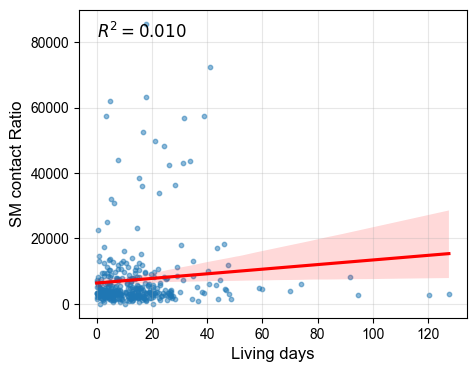

In [ ]:
from scipy.stats import linregress
# 回归线
x = overlapresult['OS_MONTHS']
y = overlapresult['ratio']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=12, color='black'
)

# 设置标题和标签
#plt.title('Scatter plot with regression line', fontsize=15)
plt.xlabel('Living days', fontsize=12)
plt.ylabel('SM contact Ratio', fontsize=12)
plt.grid(alpha=0.3)

In [ ]:
overlapresult.head()

,PATIENT_ID,OS_STATUS,OS_MONTHS,chr10_100329938_100329938,chr10_100502260_100502260,chr10_100750791_100750791,chr10_100924669_100924669,chr10_100937452_100937452,chr10_101227732_101227732,chr10_101430440_101430440,...,chrX_9725767_9725767,chrX_9894934_9894934,chrX_9896678_9896678,chrY_19731868_19731868,chrY_19735366_19735366,chrY_7080838_7080838,sum,hg38id,nonNAnum,ratio
0,TCGA-02-0003,1:DECEASED,4.730618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,264110.0,47,17,5619.361702
1,TCGA-02-0033,1:DECEASED,2.825230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,144730.0,35,9,4135.142857
2,TCGA-02-0047,1:DECEASED,14.717477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,187892.0,67,13,2804.358209
3,TCGA-02-0055,1:DECEASED,2.496715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,114524.0,55,8,2082.254545
4,TCGA-02-2466,1:DECEASED,16.787122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,194054.0,91,22,2132.461538


In [ ]:
overlapresult.iloc[:,[0,1,2,-4,-3,-2,-1]].to_csv('SM_Con_all.csv',index=False)

### 原始数据

In [ ]:
all_persample.head()

Tumor_Sample_Barcode
TCGA-02-0003-01A    47
TCGA-02-0033-01A    35
TCGA-02-0047-01A    67
TCGA-02-0055-01A    55
TCGA-02-2466-01A    91
Name: hg38id, dtype: int64

In [ ]:
# 原始数据，每个样本中SM出现的次数

orin=pd.crosstab(SNP['Tumor_Sample_Barcode'], SNP['hg38id']).gt(0).astype(int)
#orin=SNP.pivot_table(index='Tumor_Sample_Barcode',columns='hg19id',aggfunc=lambda x: 1, fill_value=0)
metaorin=pd.merge(meta_simple.iloc[:,:6],orin,left_on='PATIENT_ID',right_index=True,how='inner')

In [ ]:
metaorin['sum']=metaorin.iloc[:,6:].sum(axis=1)
metaorin.loc[:,['PATH_DIAG_TO_DEATH_DAYS','sum']].corr(method='spearman')

,PATH_DIAG_TO_DEATH_DAYS,sum
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.069639
sum,0.069639,1.000000


In [ ]:
SMsum=metaorin.iloc[:,[0,-1]].sort_values(by='sum',ascending=False).head(10)

In [ ]:
metaorin.head()

,PATIENT_ID,PATH_DIAG_TO_DEATH_DAYS,PATH_DIAG_TO_LAST_CONTACT_DAYS,CAUSE_OF_DEATH,VITAL_STATUS,LOST_TO_FOLLOW_UP,chr10_100017842_100017842,chr10_100183413_100183413,chr10_100481428_100481428,chr10_100481448_100481448,...,chrX_99854625_99854625,chrY_23710716_23710716,chrY_23710825_23710825,chrY_3447670_3447670,chrY_3447809_3447809,chrY_4925071_4925071,chrY_4925496_4925496,chrY_5605441_5605441,chrY_9304672_9304672,sum
0,C3L-00104,129.0,128.0,NaN,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,78
1,C3L-00365,322.0,280.0,NaN,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66
2,C3L-00674,478.0,385.0,GBM,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44
3,C3L-00677,155.0,155.0,GBM,Deceased,No,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1004
4,C3L-01040,NaN,608.0,NaN,Living,Yes,0,0,0,0,...,0,0,0,0,0,1,0,0,0,94


### non-overlapped SM   
从上面得到的数据

In [ ]:
# 每个 sample 的 non overlap SM的的数量
nonoverlap=all_persample-overlap_persample

In [ ]:
nonoverlap.head()

Tumor_Sample_Barcode
C3L-00104     34
C3L-00365     35
C3L-00674     27
C3L-00677    379
C3L-01040     43
Name: hg19id, dtype: int64